# Imports

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import re
import numpy as np

# Carregar os datasets tratados

In [2]:
# Carregando dados processados em formato parquet
data_df = pd.read_parquet('/home/gabipereira/tremBI/EvolucaoDaMusica-BI/data/processed_data_df.parquet')
musicdata_df = pd.read_parquet('/home/gabipereira/tremBI/EvolucaoDaMusica-BI/data/processed_musicdata_df.parquet')
charts_df = pd.read_parquet('/home/gabipereira/tremBI/EvolucaoDaMusica-BI/data/processed_charts_df.parquet')
new_df = pd.read_parquet('/home/gabipereira/tremBI/EvolucaoDaMusica-BI/data/processed_new_df.parquet')
new_artists_df = pd.read_parquet('/home/gabipereira/tremBI/EvolucaoDaMusica-BI/data/processed_new_artists_df.parquet')
final_df = pd.read_parquet('/home/gabipereira/tremBI/EvolucaoDaMusica-BI/data/processed_final_df.parquet')

# Visualização de popularidade das músicas ao longo dos anos

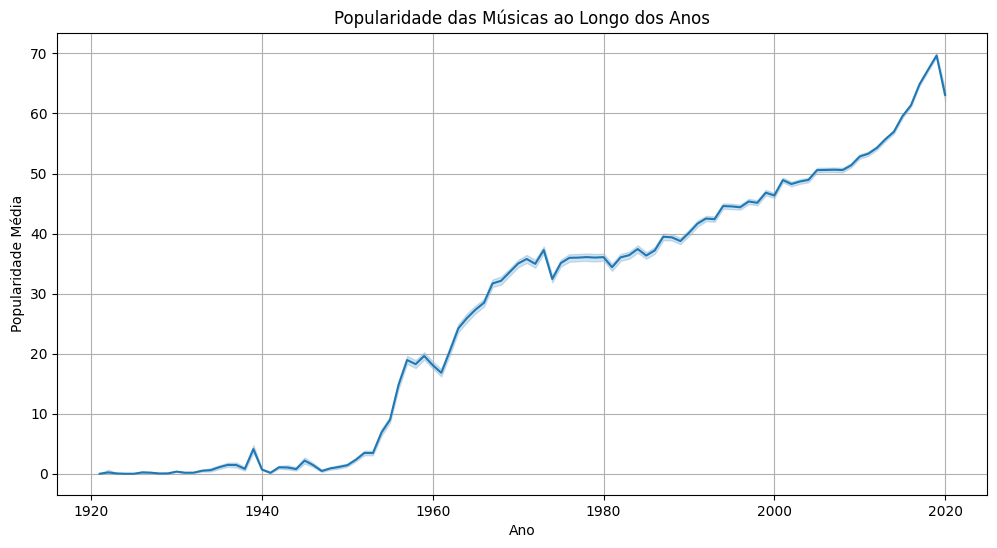

In [5]:
data_df['year'] = data_df['year'].astype(int)
data_df['popularity'] = data_df['popularity'].astype(float)

plt.figure(figsize=(12,6))
sns.lineplot(data=data_df, x='year', y='popularity')
plt.title('Popularidade das Músicas ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Popularidade Média')
plt.grid(True)
plt.show()

# Visualização dos picos de diferentes formatos de mídia

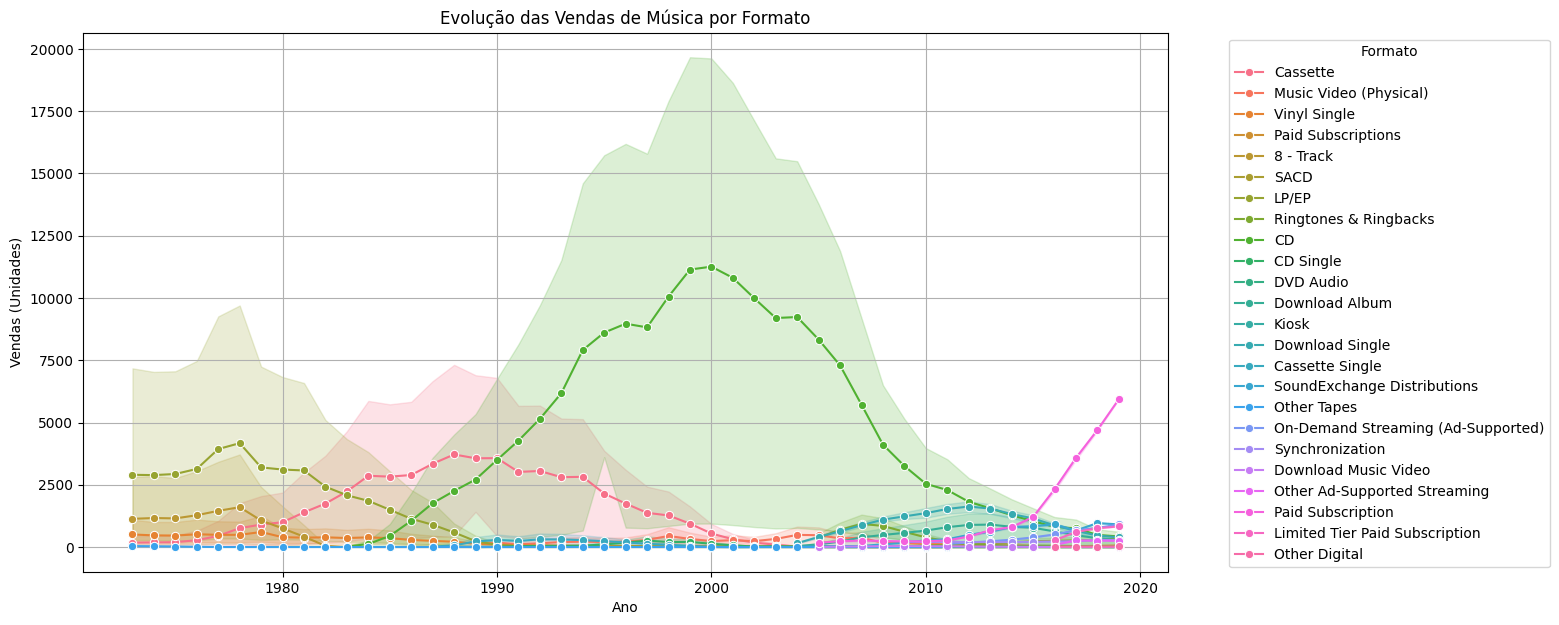

In [6]:
# Plotar os dados
plt.figure(figsize=(14, 7))
sns.lineplot(data=musicdata_df, x='year', y='value_actual', hue='format', marker='o')

plt.title('Evolução das Vendas de Música por Formato')
plt.xlabel('Ano')
plt.ylabel('Vendas (Unidades)')
plt.legend(title='Formato', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Visualização dos rankings do Billboard Hot 100
A Billboard Hot 100 é uma parada musical que classifica as 100 músicas mais populares nos Estados Unidos. O ranking é determinado por uma combinação de vendas físicas e digitais, execuções em rádio e streaming. A posição número 1 é a mais alta, significando a música mais popular da semana, e a posição 100 é a mais baixa.

- Dataset: Billboard "The Hot 100" Songs
- Link: https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs

/tmp/ipykernel_253802/1233350390.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=charts_df, x='date', y='rank', ci=None)


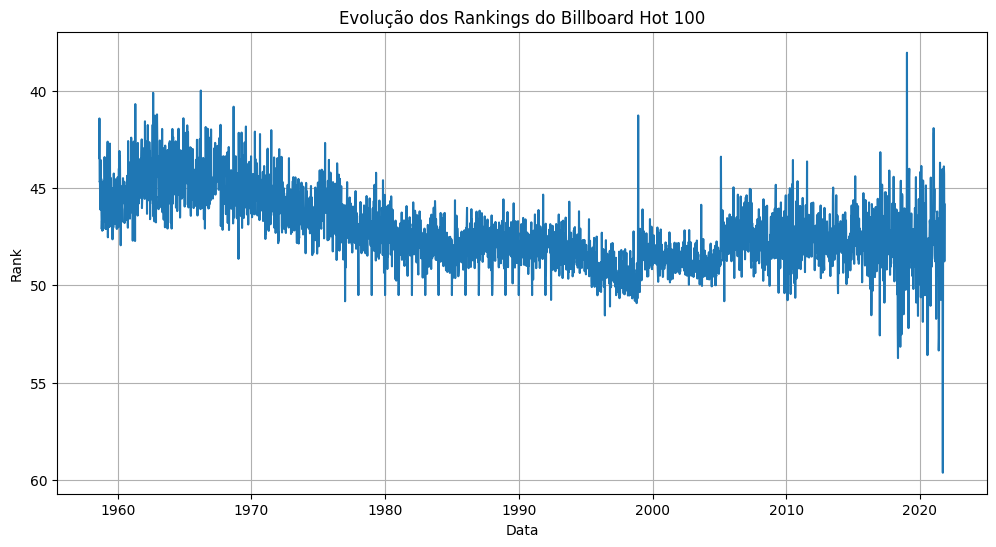

In [7]:
plt.figure(figsize=(12,6))
sns.lineplot(data=charts_df, x='date', y='rank', ci=None)
plt.gca().invert_yaxis()  # Inverte o eixo Y para que o ranking 1 esteja no topo
plt.title('Evolução dos Rankings do Billboard Hot 100')
plt.xlabel('Data')
plt.ylabel('Rank')
plt.grid(True)
plt.show()

# Artistas mais ouvidos por formato de mídia e seus generos musicais
- Dados retirados do dataset: US Top 10K Artists and Their Popular Songs
- Spotify
- Link: https://www.kaggle.com/datasets/spoorthiuk/us-top-10k-artists-and-their-popular-songs

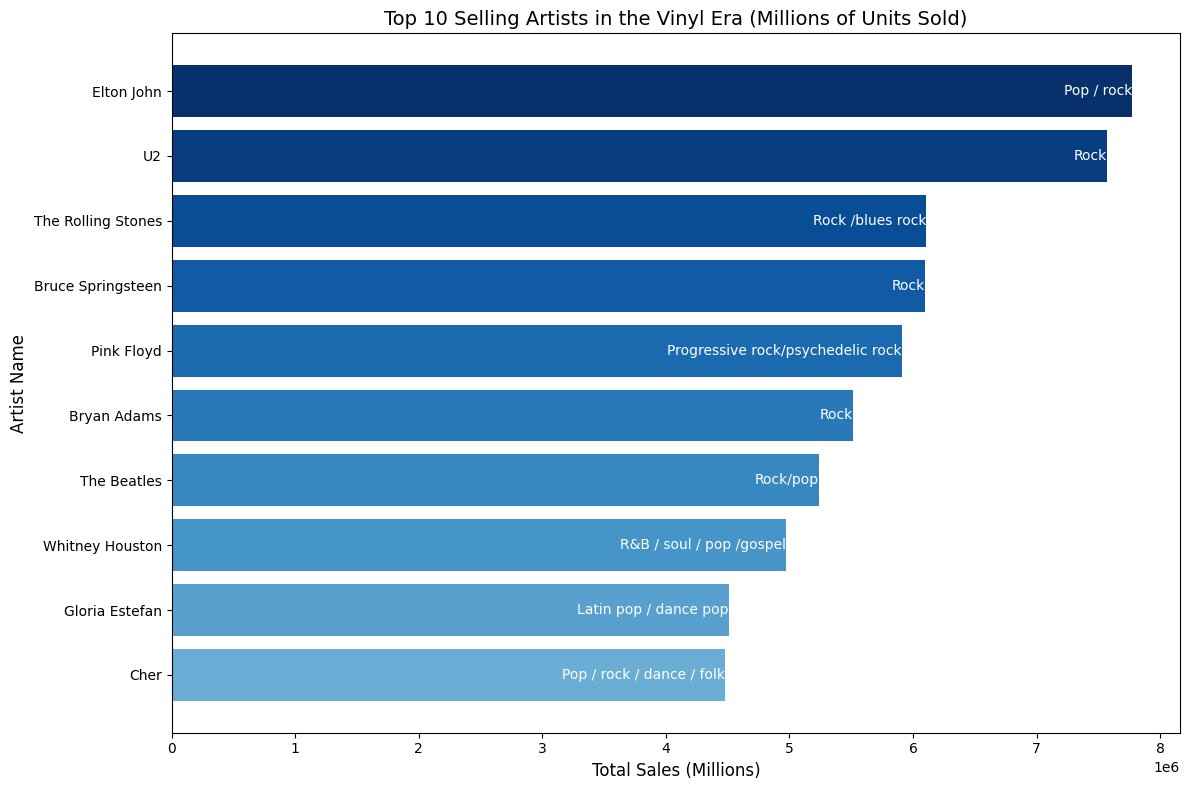

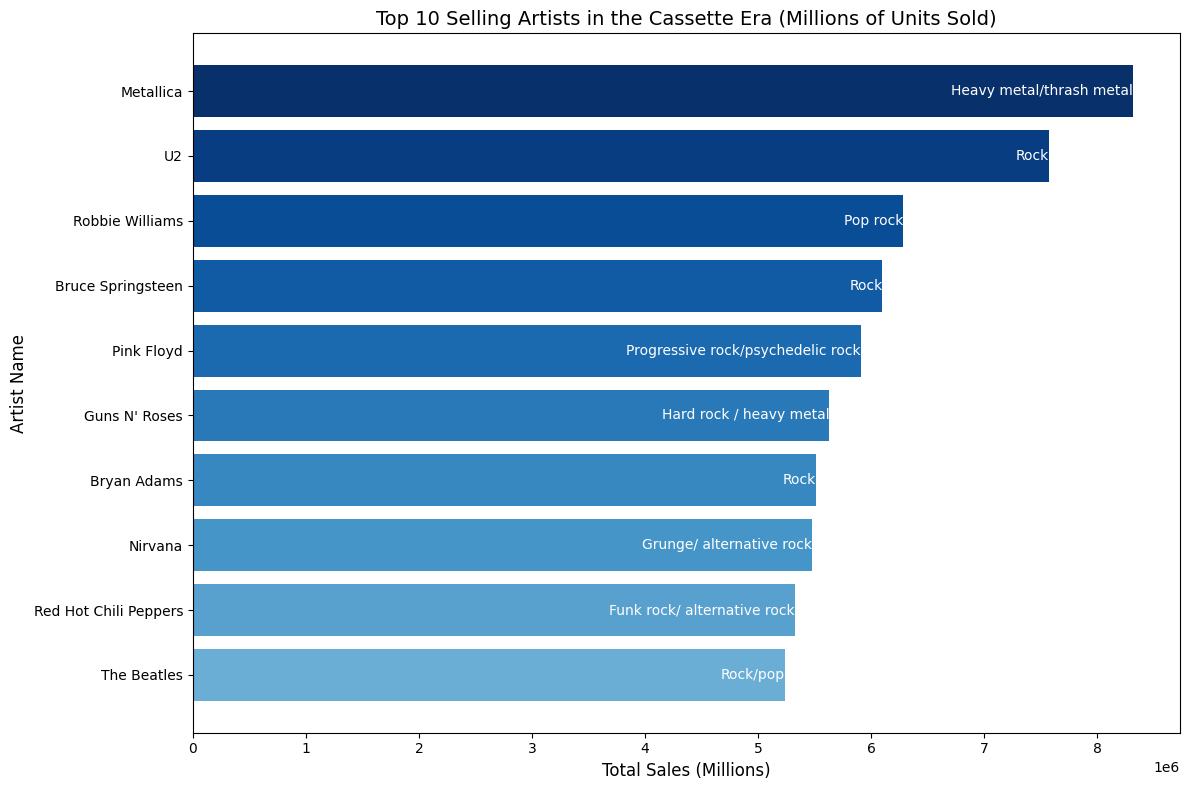

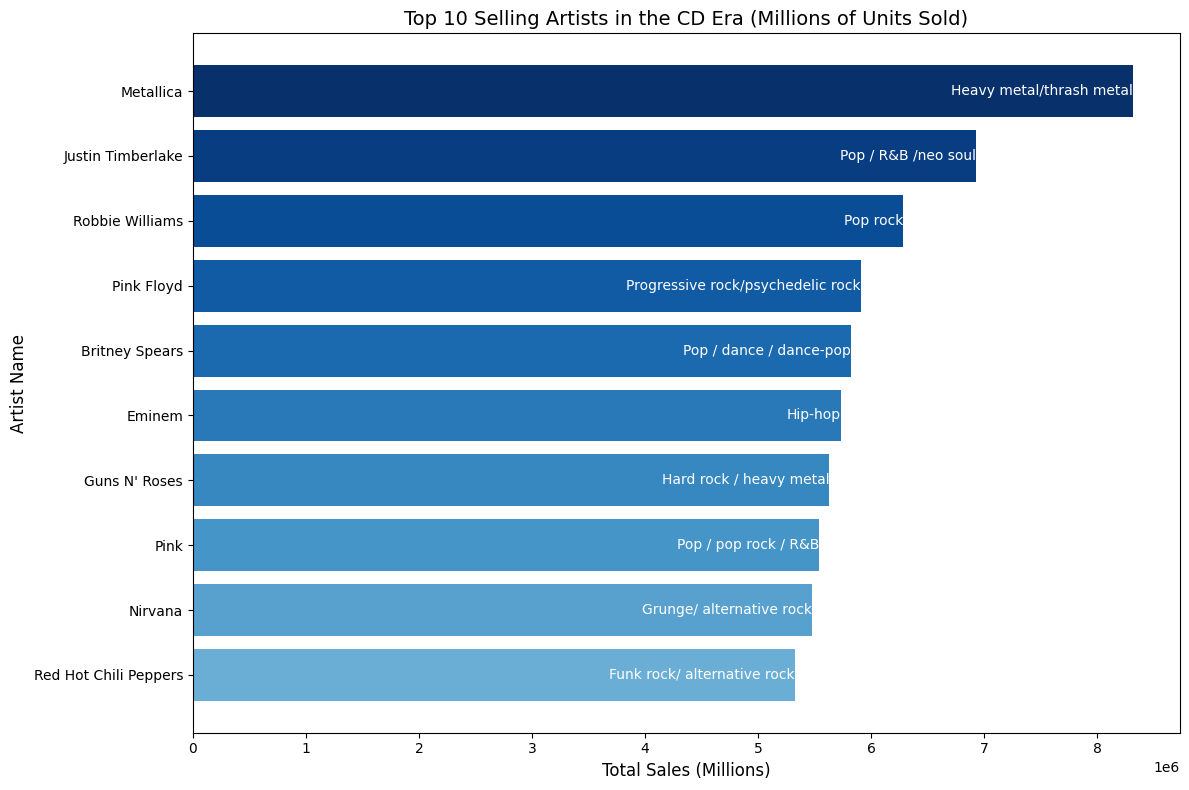

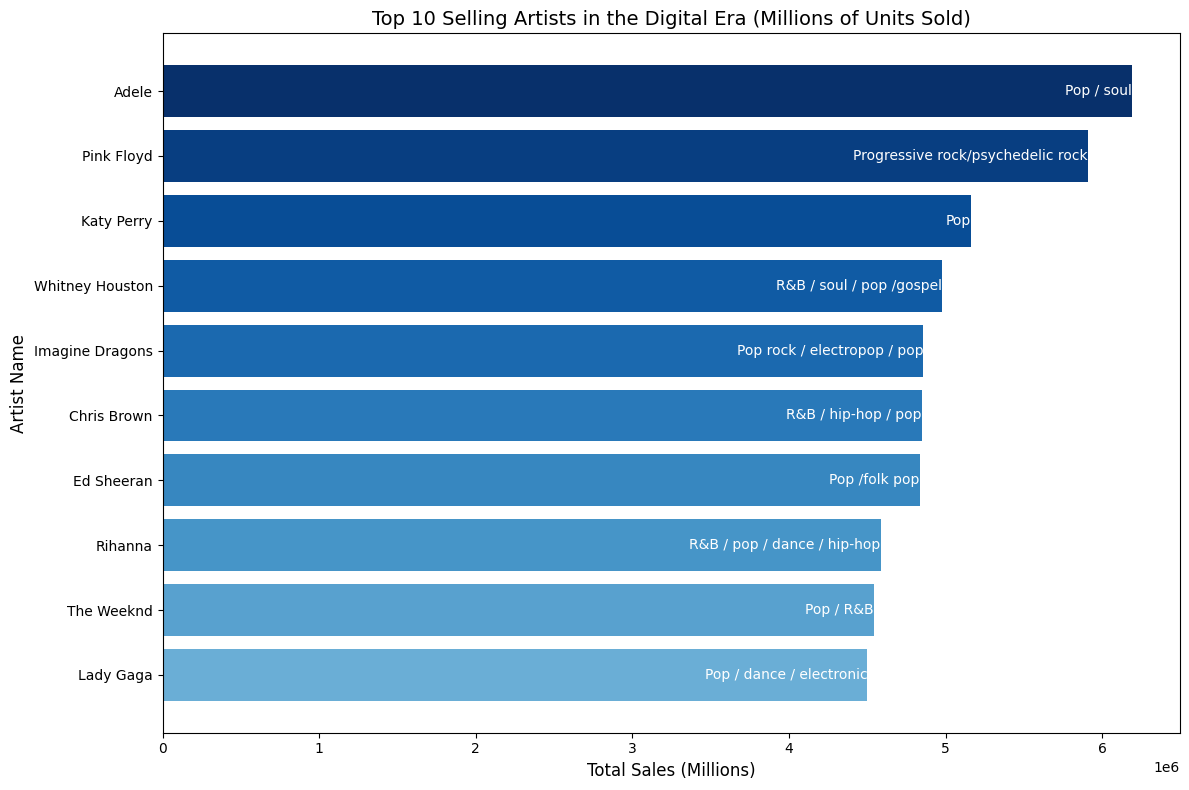

In [41]:
# Função para extrair e somar as vendas certificadas
def extract_sales(units_string):
    units = re.findall(r'(\d+(?:\.\d+)?)(?: million)?', units_string.replace(',', ''))
    return sum(float(num) for num in units)

# Aplicando a função na coluna 'Total certified units'
new_df['Total Sales (millions)'] = new_df['Total certified units'].apply(extract_sales)

# Definição das eras
eras = {
    'Vinyl Era': (1950, 1980),
    'Cassette Era': (1970, 1990),
    'CD Era': (1980, 2000),
    'Digital Era': (2000, 2020)
}

# Função para filtrar artistas ativos durante uma dada era
def filter_artists_by_era(df, start_year, end_year):
    def active_during(artist_years):
        years_active = re.findall(r'\d{4}', artist_years)
        if not years_active:
            return False
        artist_start, artist_end = int(years_active[0]), int(years_active[-1])
        return (artist_start <= end_year) and (artist_end >= start_year)
    
    return df[df['Active years'].apply(active_during)].nlargest(10, 'Total Sales (millions)')

# Filtrando artistas para cada era
top_artists_per_era = {era: filter_artists_by_era(new_df, start, end) for era, (start, end) in eras.items()}

# Função para plotar os gráficos para cada era com os gêneros musicais e cores customizadas
def plot_top_artists_with_genres_custom_colors(era_name, df):
    # Cores em degradê de azul escuro
    dark_colors = plt.cm.Blues(np.linspace(0.5, 1, len(df)))  # Invertendo o degradê para escuro no topo
    fig, ax = plt.subplots(figsize=(12, 8))
    df = df.sort_values('Total Sales (millions)', ascending=True)
    bars = ax.barh(df['Artist name'], df['Total Sales (millions)'], color=dark_colors)
    ax.set_title(f'Top 10 Selling Artists in the {era_name} (Millions of Units Sold)', fontsize=14)
    ax.set_xlabel('Total Sales (Millions)', fontsize=12)
    ax.set_ylabel('Artist Name', fontsize=12)

    # Adicionando os gêneros musicais dentro das barras
    for bar, genre in zip(bars, df['Genre']):
        text = genre.strip('[]').replace("'", "")
        ax.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, f"{text}",
                va='center', ha='right', color='white', fontsize=10)

    plt.tight_layout()
    return fig

# Gerando e exibindo os gráficos para cada era com gêneros musicais e cores personalizadas
figs = {}
for era in eras.keys():
    figs[era] = plot_top_artists_with_genres_custom_colors(era, top_artists_per_era[era])
    plt.show(figs[era])

/tmp/ipykernel_253802/2954656519.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(sorted_df['Name'], fontdict={'horizontalalignment': 'right'})
/tmp/ipykernel_253802/2954656519.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_current_popular_very_dark_colors.show()


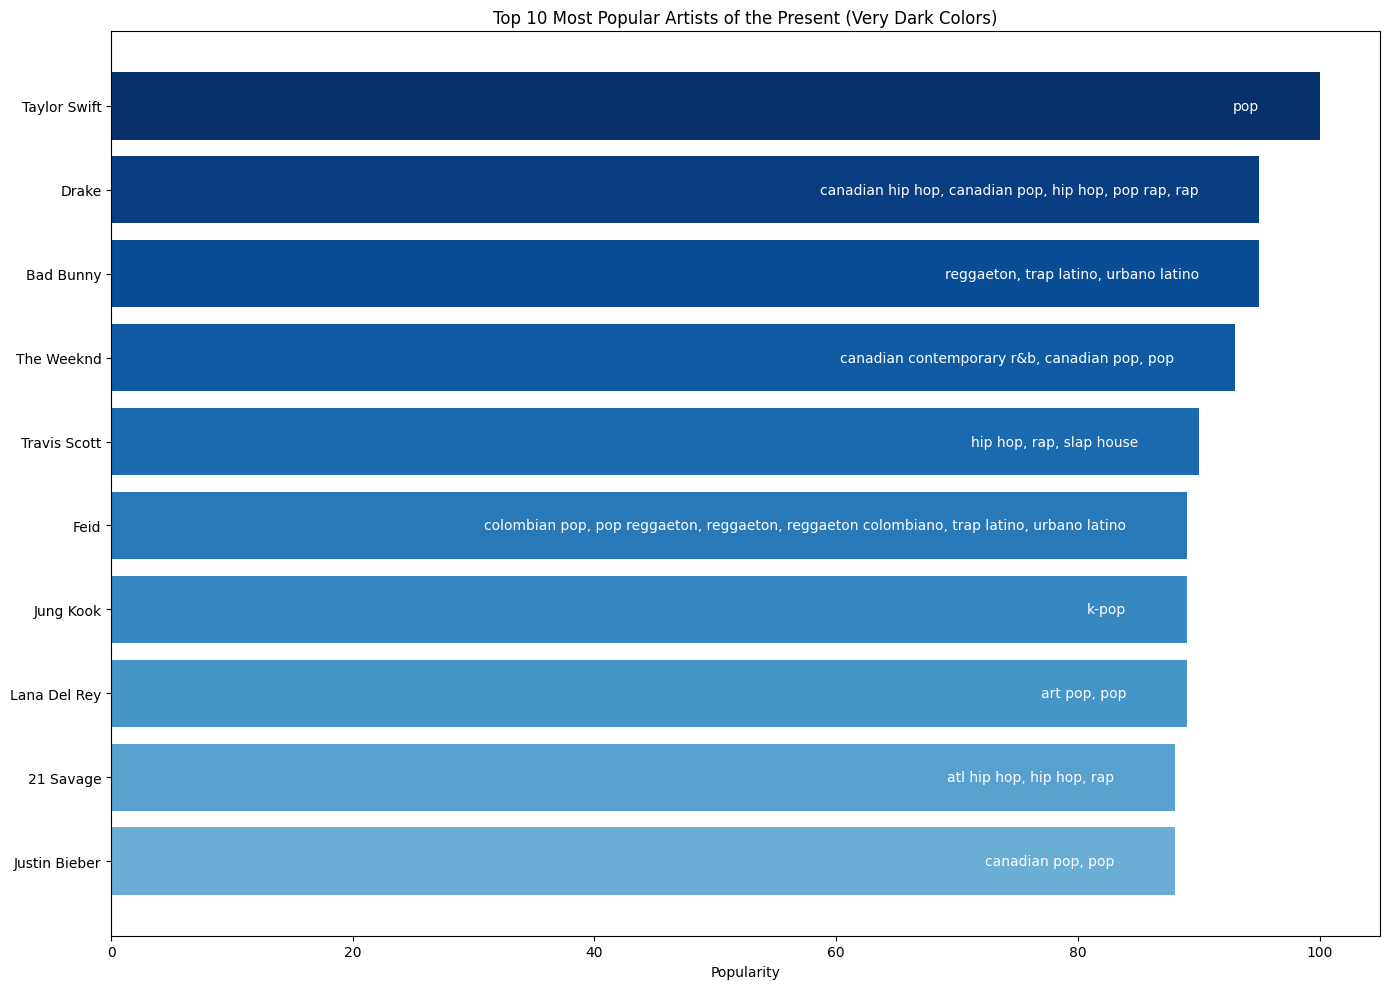

In [48]:
# Convertendo a coluna 'Popularity' para numérico e tratando NaNs
new_artists_df['Popularity'] = pd.to_numeric(new_artists_df['Popularity'], errors='coerce')
artists_df = new_artists_df.dropna(subset=['Popularity'])

# Obtendo os top 10 artistas mais populares da atualidade
top_10_current = artists_df.nlargest(10, 'Popularity')

# Função para plotar os gráficos com degradê de cores escuras
def plot_top_artists_by_popularity_very_dark_colors(df, title):
    sorted_df = df.sort_values('Popularity', ascending=True)
    # Aplicando um degradê de azul escuro, mais escuro no topo
    dark_colors = plt.cm.Blues(np.linspace(0.5, 1, len(sorted_df)))
    fig, ax = plt.subplots(figsize=(14, 10))
    bars = ax.barh(sorted_df['Name'], sorted_df['Popularity'], color=dark_colors)
    ax.set_xlabel('Popularity')
    ax.set_title(title)
    ax.set_yticklabels(sorted_df['Name'], fontdict={'horizontalalignment': 'right'})

    # Adicionando os gêneros musicais dentro das barras
    for bar, genre in zip(bars, sorted_df['Genres']):
        text = genre.strip('[]').replace("'", "")  # Limpar caracteres adicionais
        ax.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, f"{text}",
                va='center', ha='right', color='white', fontsize=10)

    plt.tight_layout()
    return fig

# Gerando e exibindo o gráfico final com cores muito escuras
fig_current_popular_very_dark_colors = plot_top_artists_by_popularity_very_dark_colors(top_10_current, 'Top 10 Most Popular Artists of the Present (Very Dark Colors)')
fig_current_popular_very_dark_colors.show()

# Artistas com mais Discos vendidos (vinil)
- Dataset somente sobre vendas de vinil

/tmp/ipykernel_253802/169425555.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_artists_vinyl_sales, x='sales', y='artist', palette='viridis')


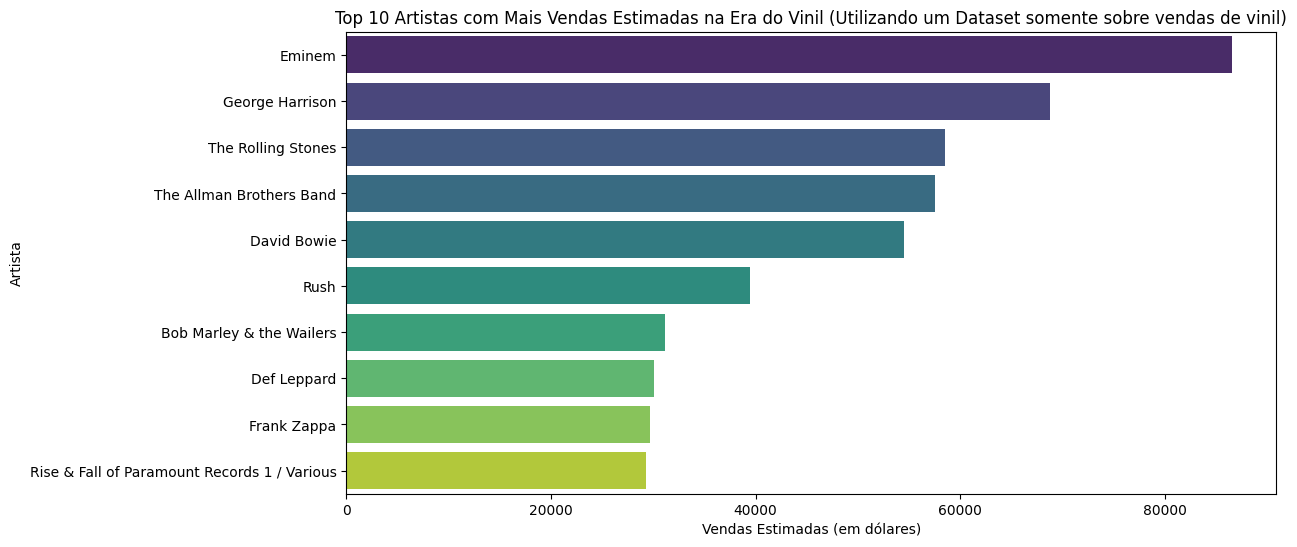

In [50]:
# Converter as colunas 'price' e 'stock' para numérico
final_df['price'] = pd.to_numeric(final_df['price'], errors='coerce')
final_df['stock'] = pd.to_numeric(final_df['stock'], errors='coerce')

# Criar uma nova coluna 'sales' estimada como price * stock
final_df['sales'] = final_df['price'] * final_df['stock']

# Excluir a linha com 'Various Artists'
final_df = final_df[final_df['artist'] != 'Various Artists']

# Agrupar por artista e somar as vendas estimadas
artists_vinyl_sales = final_df.groupby('artist')['sales'].sum().reset_index()

# Classificar os artistas pela quantidade de vendas e selecionar os top 10
top_artists_vinyl_sales = artists_vinyl_sales.sort_values(by='sales', ascending=False).head(10)

# Visualizar os resultados
plt.figure(figsize=(12,6))
sns.barplot(data=top_artists_vinyl_sales, x='sales', y='artist', palette='viridis')
plt.title('Top 10 Artistas com Mais Vendas Estimadas na Era do Vinil (Utilizando um Dataset somente sobre vendas de vinil)')
plt.xlabel('Vendas Estimadas (em dólares)')
plt.ylabel('Artista')
plt.show()